# Litecoin Price Prediction 2021

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import seaborn as sns
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,accuracy_score,mean_absolute_error
from sklearn.model_selection import train_test_split

from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.layers import Bidirectional, GRU
from keras.models import Sequential

from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from kerastuner.tuners import BayesianOptimization
from keras.regularizers import l2

## Data Preprocessing

In [5]:
df = pd.read_csv('Data/coin_Litecoin.csv')

In [6]:
df.head()

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Litecoin,LTC,2013-04-29 23:59:59,4.57360,4.22564,4.36676,4.38390,0.0,7.538896e+07
1,2,Litecoin,LTC,2013-04-30 23:59:59,4.57238,4.16896,4.40352,4.29649,0.0,7.402092e+07
2,3,Litecoin,LTC,2013-05-01 23:59:59,4.35686,3.52029,4.28954,3.80101,0.0,6.560460e+07
3,4,Litecoin,LTC,2013-05-02 23:59:59,4.03930,3.00717,3.78002,3.37198,0.0,5.828798e+07
4,5,Litecoin,LTC,2013-05-03 23:59:59,3.45361,2.39594,3.39044,3.04491,0.0,5.269485e+07


In [7]:
#spliting 'Date' column to 'date' and 'time'
df['Date'] = pd.to_datetime(df['Date'])
df['date'] = df['Date'].dt.date
df['time'] = df['Date'].dt.time

#drop non-relevant columns
df.drop(['SNo','Name','Symbol','Date','time'], axis=1, inplace=True)

#set date as new index
df.set_index('date',inplace=True)

df.head()

,High,Low,Open,Close,Volume,Marketcap
date,,,,,,
2013-04-29,4.57360,4.22564,4.36676,4.38390,0.0,7.538896e+07
2013-04-30,4.57238,4.16896,4.40352,4.29649,0.0,7.402092e+07
2013-05-01,4.35686,3.52029,4.28954,3.80101,0.0,6.560460e+07
2013-05-02,4.03930,3.00717,3.78002,3.37198,0.0,5.828798e+07
2013-05-03,3.45361,2.39594,3.39044,3.04491,0.0,5.269485e+07


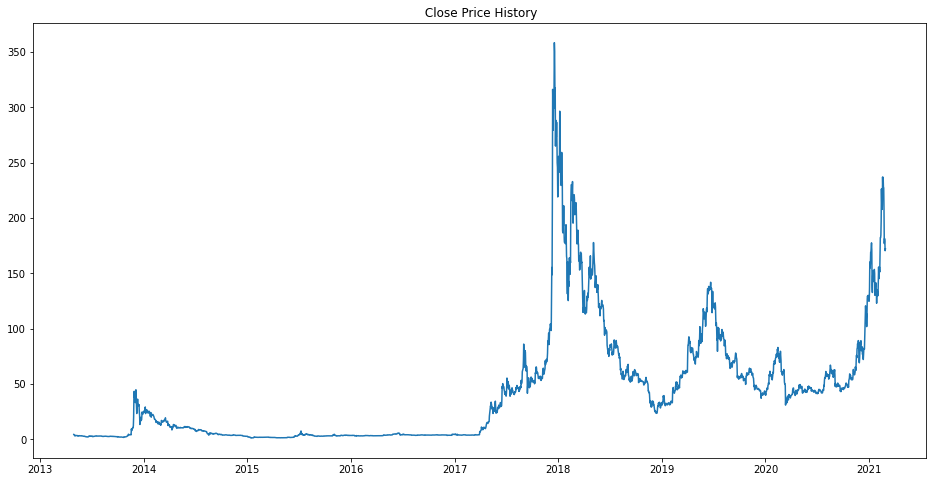

In [8]:
plt.figure(figsize=(16,8))
plt.title(' Close Price History')
plt.plot(df['Close'])

## Train, Validation and Test Data

In [9]:
n = df.shape[0]
train_df = df[0:int(n*.7)]
val_df = df[int(n*0.7):int(n*0.85)]
test_df = df[int(n*0.85):]

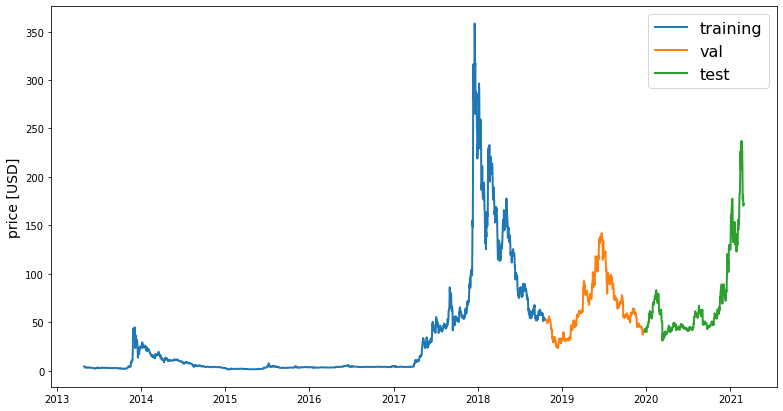

In [10]:
def line_plot2(line1, line2,label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)

def line_plot3(line1, line2,line3, label1=None, label2=None,label3=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.plot(line3, label=label3, linewidth=lw)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)


line_plot3(line1 = train_df.filter(['Close']), 
          line2 = val_df.filter(['Close']),
          line3 = test_df.filter(['Close']), label1='training',label2='val',label3= 'test', title='')

## Data Normalization

In [11]:
def scale_func(df):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df)
    scaled_data = pd.DataFrame(scaled_data,index=df.index, columns=df.columns)
    return scaled_data, scaler

scaled_train_df, scaler  = scale_func(train_df) 
scaled_val_df = pd.DataFrame(scaler.transform(val_df),index=val_df.index,columns=val_df.columns)
scaled_test_df = pd.DataFrame(scaler.transform(test_df),index=test_df.index,columns=test_df.columns)

In [12]:
#create the training data set
def generate_input(df, window, target):
    #create the scaled training data set
    #Split the data into x_train and y_train data sets
    x_train = []
    y_train = []
    for i in range(window, len(df)):
        x_train.append(df.iloc[i-window:i, :][target])
        y_train.append(df.iloc[i,:,][target])
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    return x_train, y_train
def multiinput_generator(df, target, window):
    feature_cols = df.columns  
    x_train = []
    y_train = []
    for i in range(window, len(df)):
        x_train.append(df.iloc[i-window:i,:])
        y_train.append(df.iloc[i,:][target])
    #convert x_train and y_train to numpy arrays
    x_train, y_train = np.array(x_train), np.array(y_train)
    return x_train,y_train


In [14]:
x_train_multi, y_train_multi = multiinput_generator(scaled_train_df, "Close", 15)
x_val_multi, y_val_multi = multiinput_generator(scaled_val_df, "Close", 15)
x_test_multi, y_test_multi = multiinput_generator(scaled_test_df, "Close", 15)
print("Training set multiple input:",x_train_multi.shape)
print("Validation set multiple input:",x_val_multi.shape)
print("Test set multiple input:",x_test_multi.shape)

Training set multiple input: (1988, 15, 6)
Validation set multiple input: (414, 15, 6)
Test set multiple input: (415, 15, 6)


## Modeling

In [15]:
def model_base_build(input_shape):
    #build the lstm model
    model = Sequential()
    model.add(LSTM(100, return_sequences=True,kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01), input_shape = input_shape))
    model.add(LSTM(50, return_sequences=False, dropout=0.4, recurrent_dropout=0.4))
    model.add(Dense(1))
    model.add(Activation('linear'))
    #compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def model_class_build(input_shape):
    #build the lstm model
    model = Sequential()
    #### Adding the first LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 50, return_sequences = True, input_shape = input_shape))
    model.add(Dropout(0.2))
    #### Adding a second LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))
    #### Adding a third LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))
    #### Adding a fourth LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 50))
    model.add(Dropout(0.2))
    #### Adding the output layer
    model.add(Dense(units = 1))
    model.add(Activation('linear'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def model_GRU_build(input_shape):
    model = Sequential()
    # Input layer
    model.add(GRU(125,kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01), return_sequences = True, input_shape = input_shape))
    model.add(Dropout(0.4)) 
    # Hidden layer
    model.add(GRU(125)) 
    model.add(Dropout(0.4))
    model.add(Dense(1))
    model.add(Activation('linear'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def biLSTM_model(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(210,kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01), return_sequences=True, input_shape = (x_train.shape[1],1))))
    model.add(Dropout(0.4))
    model.add(Bidirectional(LSTM(215)))
    model.add(Dropout(0.4))
    model.add(Dense(1))
    model.add(Activation('linear'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [16]:
def accuracy_forecast(target_val ,prediction_val):   
    bi_targ = np.sign(target_val.rolling(window=2).apply(lambda x: x.iloc[1] - x.iloc[0]))[1:].values
    bi_pred = np.sign(prediction_val.rolling(window=2).apply(lambda x: x.iloc[1] - x.iloc[0]))[1:].values
    return accuracy_score(bi_targ,bi_pred)

In [17]:
LSTM1_multi = model_base_build(input_shape= (x_train_multi.shape[1],x_train_multi.shape[2]))
LSTM2_multi = model_class_build(input_shape= (x_train_multi.shape[1],x_train_multi.shape[2]))
GRU_model_multi = model_GRU_build(input_shape= (x_train_multi.shape[1],x_train_multi.shape[2]))
biLSTM_multi = biLSTM_model(input_shape= (x_train_multi.shape[1],x_train_multi.shape[2]))

In [18]:
#train the model
history1M = LSTM1_multi.fit(x_train_multi, y_train_multi, batch_size=32, epochs=80,validation_data=(x_val_multi,y_val_multi))
history2M = LSTM2_multi.fit(x_train_multi, y_train_multi, batch_size=32, epochs=80,validation_data=(x_val_multi,y_val_multi))
history3M = GRU_model_multi.fit(x_train_multi, y_train_multi, batch_size=32, epochs=80,validation_data=(x_val_multi,y_val_multi))
history4M = biLSTM_multi.fit(x_train_multi, y_train_multi, batch_size=32, epochs=80,validation_data=(x_val_multi,y_val_multi))

Epoch 1/80
63/63 [==============================] - 36s 67ms/step - loss: 1.7171 - val_loss: 1.0249
Epoch 2/80
63/63 [==============================] - 3s 55ms/step - loss: 0.9480 - val_loss: 0.7901
Epoch 3/80
63/63 [==============================] - 3s 54ms/step - loss: 0.7583 - val_loss: 0.6749
Epoch 4/80
63/63 [==============================] - 3s 54ms/step - loss: 0.6510 - val_loss: 0.5870
Epoch 5/80
63/63 [==============================] - 3s 55ms/step - loss: 0.5623 - val_loss: 0.5049
Epoch 6/80
63/63 [==============================] - 4s 56ms/step - loss: 0.4839 - val_loss: 0.4363
Epoch 7/80
63/63 [==============================] - 4s 56ms/step - loss: 0.4149 - val_loss: 0.3727
Epoch 8/80
63/63 [==============================] - 3s 55ms/step - loss: 0.3543 - val_loss: 0.3185
Epoch 9/80
63/63 [==============================] - 3s 55ms/step - loss: 0.2999 - val_loss: 0.2691
Epoch 10/80
63/63 [==============================] - 3s 54ms/step - loss: 0.2526 - val_loss: 0.2238
Epoch 11

## Model Evaluation

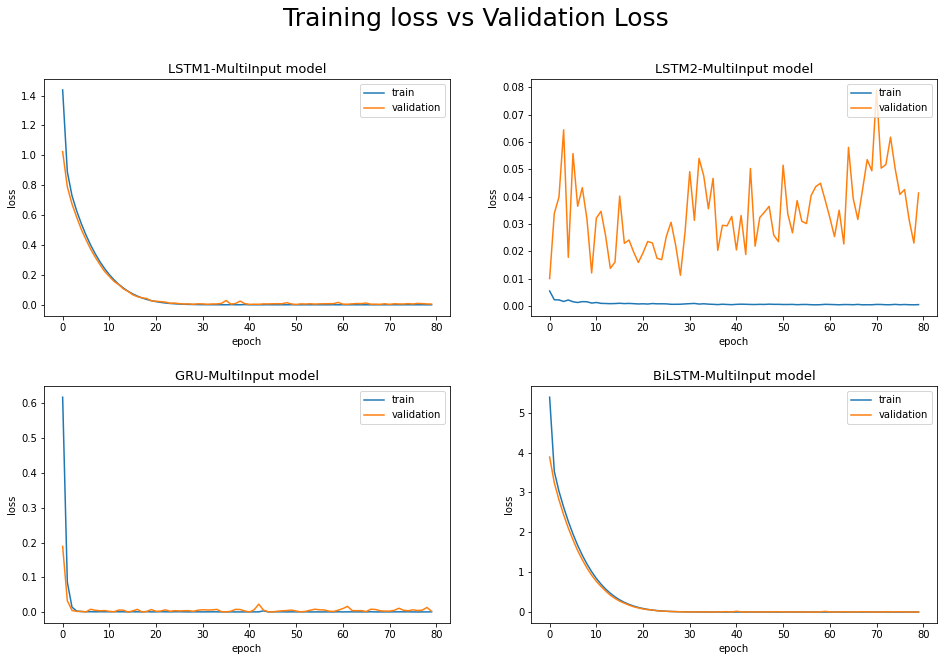

In [19]:
def plot_loss_histories(histories,names):
    rows = math.ceil(len(histories)/2)
    fig, axes = plt.subplots(rows,2, constrained_layout=False, figsize=(16,5*rows))
    fig.suptitle("Training loss vs Validation Loss\n", fontsize=25)
    # Draw nested boxplots
    for history, name, ax in zip(histories, names , axes.flatten()):
        ax.plot(history.history['loss'])
        ax.plot(history.history['val_loss'])
        ax.set_title("{} model".format(name), fontsize=13)
        ax.set_xlabel('epoch')
        ax.set_ylabel('loss')
        ax.legend(['train', 'validation'], loc='upper right')
    fig.subplots_adjust(hspace=0.3)
    plt.show()
    
histories = [history1M,history2M,history3M,history4M]
names = ['LSTM1-MultiInput','LSTM2-MultiInput','GRU-MultiInput','BiLSTM-MultiInput']
plot_loss_histories(histories,names)

## Prediction
### 1. Valid Set

In [20]:
def pred_val(model, df, input):
    target_scaler = MinMaxScaler()
    target_scaler.fit(train_df[['Close']])
    #Get the models predicted price values
    predictions = model.predict(input)
    predictions = target_scaler.inverse_transform(predictions)
    valid=df[15:][['Close']].copy()
    valid['Predictions'] = predictions
    #get the root mean squared error (RMSE)
    rmse = np.sqrt(np.mean(valid['Predictions'] - valid['Close']) ** 2)
    print("RMSE:",rmse)
    print("Accuracy:",accuracy_forecast(valid['Close'], valid['Predictions']),'\n')
    return predictions, rmse

scores = {}
print('LSTM1_MultiInput')
LSTM1_MI_pred_val, rmse = pred_val(LSTM1_multi,val_df,x_val_multi)
scores['LSTM1_MultiInput'] = rmse
print('LSTM2_MultiInput')
LSTM2_MI_pred_val, rmse = pred_val(LSTM2_multi,val_df,x_val_multi)
scores['LSTM2_MultiInput'] = rmse
print('GRU_MultiInput')
GRU_MI_pred_val, rmse = pred_val(GRU_model_multi,val_df,x_val_multi)
scores['GRU_MultiInput'] = rmse
print('BiLSTM_MultiInput')
bilstm_MI_pred_val, rmse = pred_val(biLSTM_multi,val_df,x_val_multi)
scores['BiLSTM_MultiInput'] = rmse

LSTM1_MultiInput
RMSE: 23.124285784622103
Accuracy: 0.4648910411622276 

LSTM2_MultiInput
RMSE: 50.46364721498833
Accuracy: 0.5060532687651331 

GRU_MultiInput
RMSE: 16.85585512546157
Accuracy: 0.46973365617433416 

BiLSTM_MultiInput
RMSE: 6.592126716463814
Accuracy: 0.5060532687651331 



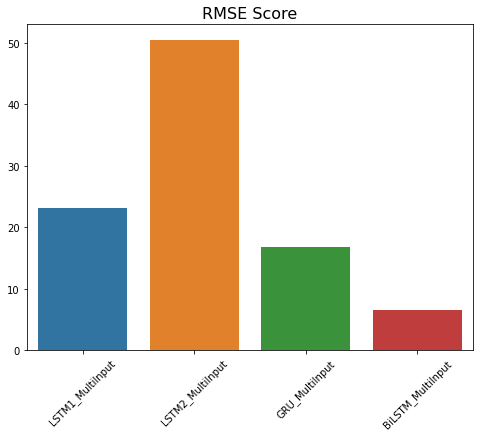

In [21]:
plt.figure(figsize=(8, 6))
sns.barplot(y = pd.Series(scores).values, x = pd.Series(scores).index)
plt.xticks(rotation=0)
plt.title('RMSE Score', fontsize=16)
plt.xticks(rotation = 45)
plt.show()

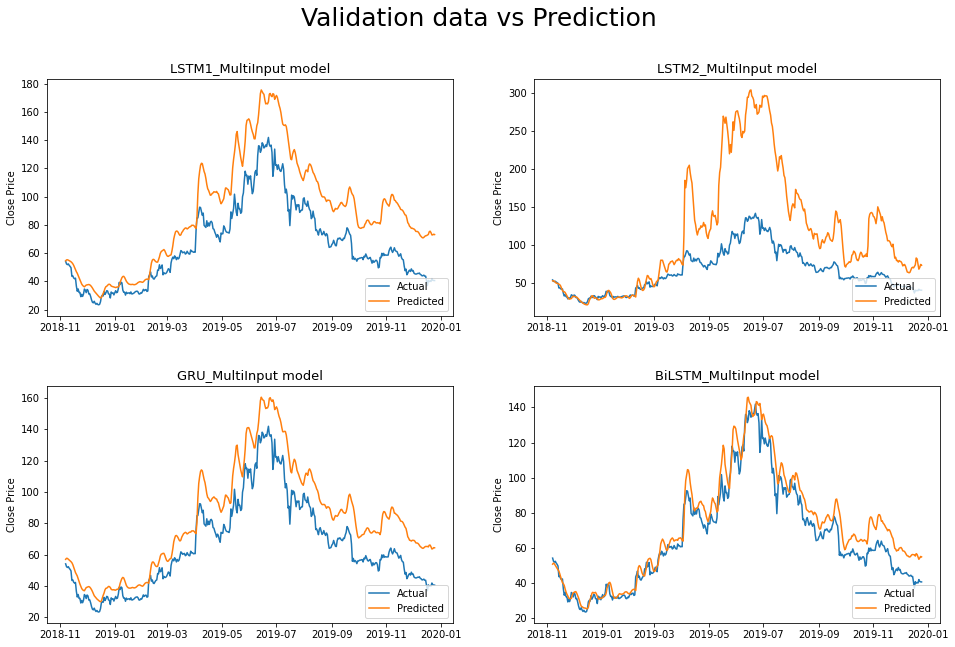

In [22]:
def plot_predictions(predictions,names):
    rows = math.ceil(len(predictions)/2)
    fig, axes = plt.subplots(rows,2, constrained_layout=False, figsize=(16,5*rows))
    fig.suptitle("Validation data vs Prediction\n", fontsize=25)
    # Draw nested boxplots
    for prediction, name, ax in zip(predictions, names , axes.flatten()):
        valid = val_df[['Close']][15:].copy()
        valid['Predictions'] = prediction
        ax.plot(valid[['Close', 'Predictions']])
        ax.set_title("{} model".format(name), fontsize=13)
        ax.set_ylabel('Close Price')
        ax.legend(['Actual', 'Predicted'], loc='lower right')
    fig.subplots_adjust(hspace=0.3)
    plt.show()

predictions = [LSTM1_MI_pred_val, LSTM2_MI_pred_val, GRU_MI_pred_val, bilstm_MI_pred_val]
names = ['LSTM1_MultiInput','LSTM2_MultiInput','GRU_MultiInput','BiLSTM_MultiInput']
plot_predictions(predictions,names)


### 2.Test Set

In [23]:
n = df.shape[0]
train_df = df[0:int(n*.85)]
test_df = df[int(n*0.85):]

def scale_func(df):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df)
    scaled_data = pd.DataFrame(scaled_data,index=df.index, columns=df.columns)
    return scaled_data, scaler

scaled_train_df, scaler  = scale_func(train_df) 
scaled_test_df = pd.DataFrame(scaler.transform(test_df),index=test_df.index,columns=test_df.columns)

In [24]:
x_train_multi, y_train_multi = multiinput_generator(scaled_train_df, "Close", 15)
x_test_multi, y_test_multi = multiinput_generator(scaled_test_df, "Close", 15)
print("Training set multiple input:",x_train_multi.shape)
print("Test set multiple input:",x_test_multi.shape)

Training set multiple input: (2417, 15, 6)
Test set multiple input: (415, 15, 6)


In [25]:
LSTM1 = model_base_build(input_shape= (x_train.shape[1],x_train.shape[2]))
LSTM2 = model_class_build(input_shape= (x_train.shape[1],x_train.shape[2]))
GRU_model = model_GRU_build(input_shape= (x_train.shape[1],x_train.shape[2]))
biLSTM = biLSTM_model(input_shape= (x_train.shape[1],x_train.shape[2]))

In [31]:
#train the model
history1M = LSTM1_multi.fit(x_train_multi, y_train_multi, batch_size=32, epochs=80,validation_data=(x_val_multi,y_val_multi))
history2M = LSTM2_multi.fit(x_train_multi, y_train_multi, batch_size=32, epochs=80,validation_data=(x_val_multi,y_val_multi))
history3M = GRU_model_multi.fit(x_train_multi, y_train_multi, batch_size=32, epochs=80,validation_data=(x_val_multi,y_val_multi))
history4M = biLSTM_multi.fit(x_train_multi, y_train_multi, batch_size=32, epochs=80,validation_data=(x_val_multi,y_val_multi))

Epoch 1/80
76/76 [==============================] - 4s 55ms/step - loss: 0.0011 - val_loss: 6.9393e-04
Epoch 2/80
76/76 [==============================] - 4s 55ms/step - loss: 9.2676e-04 - val_loss: 5.0614e-04
Epoch 3/80
76/76 [==============================] - 4s 54ms/step - loss: 8.7318e-04 - val_loss: 5.1412e-04
Epoch 4/80
76/76 [==============================] - 4s 54ms/step - loss: 9.4529e-04 - val_loss: 0.0014
Epoch 5/80
76/76 [==============================] - 4s 54ms/step - loss: 0.0010 - val_loss: 4.3618e-04
Epoch 6/80
76/76 [==============================] - 4s 54ms/step - loss: 0.0011 - val_loss: 5.8336e-04
Epoch 7/80
76/76 [==============================] - 4s 55ms/step - loss: 0.0010 - val_loss: 4.8059e-04
Epoch 8/80
76/76 [==============================] - 4s 54ms/step - loss: 9.7726e-04 - val_loss: 5.3234e-04
Epoch 9/80
76/76 [==============================] - 4s 55ms/step - loss: 9.9026e-04 - val_loss: 5.1211e-04
Epoch 10/80
76/76 [==============================] - 4s 5

In [32]:
scores = {}
print('LSTM1_MultiInput')
LSTM1_MI_pred_val, rmse = pred_val(LSTM1_multi,test_df,x_test_multi)
scores['LSTM1_MultiInput'] = rmse
print('LSTM2_MultiInput')
LSTM2_MI_pred_val, rmse = pred_val(LSTM2_multi,test_df,x_test_multi)
scores['LSTM2_MultiInput'] = rmse
print('GRU_MultiInput')
GRU_MI_pred_val, rmse = pred_val(GRU_model_multi,test_df,x_test_multi)
scores['GRU_MultiInput'] = rmse
print('BiLSTM_MultiInput')
bilstm_MI_pred_val, rmse = pred_val(biLSTM_multi,test_df,x_test_multi)
scores['BiLSTM_MultiInput'] = rmse

LSTM1_MultiInput
RMSE: 6.821877983451116
Accuracy: 0.4613526570048309 

LSTM2_MultiInput
RMSE: 4.42040505070451
Accuracy: 0.4975845410628019 

GRU_MultiInput
RMSE: 3.2456451363719188
Accuracy: 0.4806763285024155 

BiLSTM_MultiInput
RMSE: 2.1526413692894275
Accuracy: 0.4758454106280193 



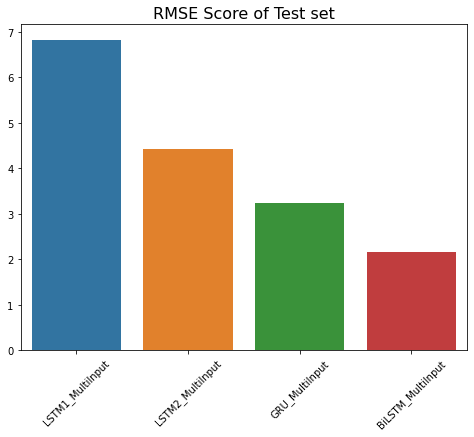

In [33]:
plt.figure(figsize=(8, 6))
sns.barplot(y = pd.Series(scores).values, x = pd.Series(scores).index)
plt.xticks(rotation=0)
plt.title('RMSE Score of Test set', fontsize=16)
plt.xticks(rotation = 45)
plt.show()

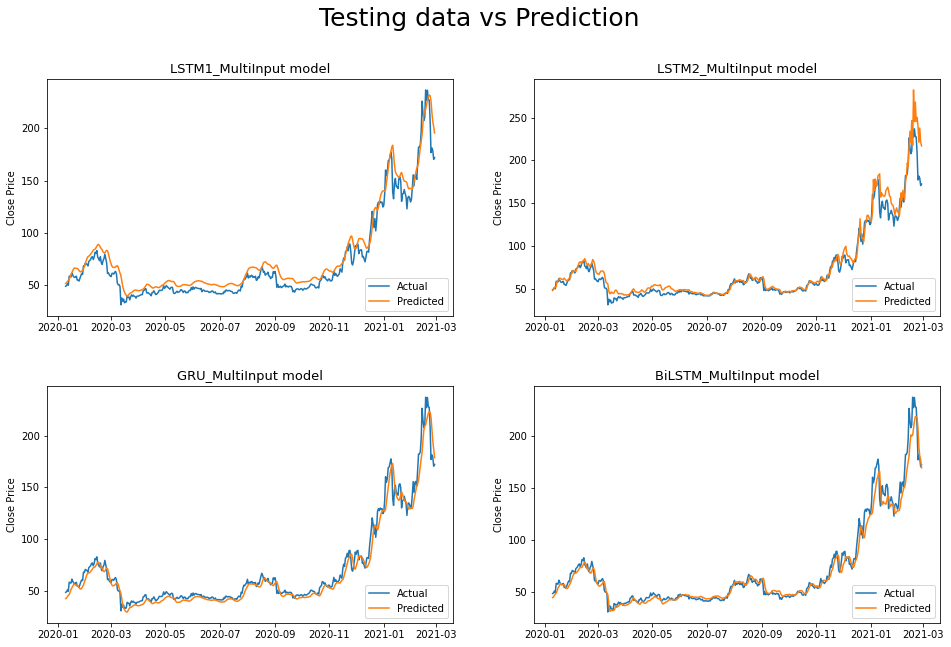

In [34]:
def plot_predictions(predictions,names):
    rows = math.ceil(len(predictions)/2)
    fig, axes = plt.subplots(rows,2, constrained_layout=False, figsize=(16,5*rows))
    fig.suptitle("Testing data vs Prediction\n", fontsize=25)
    # Draw nested boxplots
    for prediction, name, ax in zip(predictions, names , axes.flatten()):
        valid = test_df[['Close']][15:].copy()
        valid['Predictions'] = prediction
        ax.plot(valid[['Close', 'Predictions']])
        ax.set_title("{} model".format(name), fontsize=13)
        ax.set_ylabel('Close Price')
        ax.legend(['Actual', 'Predicted'], loc='lower right')
    fig.subplots_adjust(hspace=0.3)
    plt.show()


predictions = [LSTM1_MI_pred_val, LSTM2_MI_pred_val, GRU_MI_pred_val, bilstm_MI_pred_val]
names = ['LSTM1_MultiInput','LSTM2_MultiInput','GRU_MultiInput','BiLSTM_MultiInput']
plot_predictions(predictions,names)